In [1]:
import numpy as np
import pandas as pd 
import fbprophet 
import plotly
import statsmodels
from statsmodels.tsa.stattools import acf
from matplotlib import pyplot
import altair as alt
import scipy
from scipy import signal
import spectrum 
from spectrum import WelchPeriodogram
from spectrum import Periodogram
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
flu_data = pd.read_csv('flu.csv', header = 2, sep = ',')

In [3]:
flu_data.head(n=5)

,Country,WHOREGION,FLUREGION,Year,Week,SDATE,EDATE,SPEC_RECEIVED_NB,SPEC_PROCESSED_NB,AH1,...,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B,ALL_INF,ALL_INF2,TITLE
0,United States of America,Region of the Americas of WHO,North America,2013,1,2012-12-31,2013-01-06,18219,18219,0.0,...,0.0,1653,5377,0,0,1097,1097,6474,NaN,Widespread Outbreak
1,United States of America,Region of the Americas of WHO,North America,2013,2,2013-01-07,2013-01-13,20013,20013,0.0,...,0.0,1767,5752,0,0,1145,1145,6897,NaN,Widespread Outbreak
2,United States of America,Region of the Americas of WHO,North America,2013,3,2013-01-14,2013-01-20,19228,19228,0.0,...,0.0,1624,4858,0,0,1078,1078,5936,NaN,Widespread Outbreak
3,United States of America,Region of the Americas of WHO,North America,2013,4,2013-01-21,2013-01-27,17139,17139,0.0,...,0.0,1528,4039,0,0,1091,1091,5130,NaN,Widespread Outbreak
4,United States of America,Region of the Americas of WHO,North America,2013,5,2013-01-28,2013-02-03,14795,14795,0.0,...,0.0,951,2963,0,0,1076,1076,4039,NaN,Widespread Outbreak


## Utility Functions

phis = State_est$phi
s  = 20

trainingSize = 120
horizon = 90
ASEHolder = numeric()
e = NULL


for( i in 1:(249-(trainingSize + horizon) + 1))
{
 
  forecasts = fore.aruma.wge(State_level$percent_tests[i:(i+(trainingSize-1))],phi = phis, s = s, n.ahead = horizon, lastn = TRUE, plot = FALSE)
  
  ASE = mean((State_level$percent_tests[(trainingSize+i):(trainingSize+ i + (horizon) - 1)] - forecasts$f)^2)
         
  ASEHolder[i] = ASE
  
  e = rbind(e, data.frame(i,forecasts$f))


}

#ASEHolder

mod_90_State_ASE = ASEHolder

hist(ASEHolder)

In [4]:
def arima_window_ase(data_series, train_ratio = .60, order = (0,0,0)): 
    X_series = data_series.values
    size = int(len(X_series)*train_ratio)
    train,test = X_series[0:size], X_series[size:len(X_series)]
    history = [i for i in train]
    preds = list()
    for t in range(len(test)): 
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        fore_cast = model_fit.forecast()
        yhat = fore_cast[0]
        preds.append(yhat)
        obs = test[t]
        history.append(obs)
    rmse = sqrt(mean_squared_error(test, preds))
    pyplot.plot(test)
    pyplot.plot(preds, color='red')
    pyplot.show()
    
    return rmse

In [5]:
def make_realization(data_frame,x,y): 
    
    vis = alt.Chart(data_frame).mark_line().encode(
    x = x, 
    y = y
    )
    
    return vis

In [6]:
def make_autocorr(data_series, nlags=40, fft = False): 
    auto_corr = statsmodels.tsa.stattools.acf(data_series, nlags=nlags, fft=fft)
    data = pd.DataFrame(list(enumerate(auto_corr)), columns = ['Lag', 'AutoCor'])
    vis = alt.Chart(data).mark_bar().encode(
    x='Lag',
    y='AutoCor',
    )
    return vis

In [7]:
def make_sig_periodgram(data_series, fs = 1, scaling = 'density'): 
    f, Pxx_den = scipy.signal.periodogram(data_series, fs = fs, scaling=scaling)
    data = pd.DataFrame({'Freq' : f,'Density' : Pxx_den})
    vis = alt.Chart(data).mark_bar().encode(
        x='Freq',
        y='Density',
    )
    return vis

In [8]:
def make_welch_sig_periodgram(data_series, fs = 1, nperseg=50): 
    f, Pxx_den = scipy.signal.welch(flu_data.SPEC_RECEIVED_NB, fs = 1, nperseg=nperseg)
    data = pd.DataFrame({'Freq' : f,'Density' : Pxx_den})
    vis = alt.Chart(data).mark_bar().encode(
        x='Freq',
        y='Density',
    )
    return vis

In [9]:
def make_welch_periodgram(data_series, sampling = 50):
    psd = WelchPeriodogram(data_series, sampling)
    return psd[1]

In [10]:
make_realization(flu_data, 'EDATE:T', 'SPEC_RECEIVED_NB')

alt.Chart(...)

In [11]:
alt.Chart(flu_data).mark_line().encode(
    x='EDATE:T',
    y='SPEC_RECEIVED_NB'
)


alt.Chart(...)

In [12]:
series = flu_data.SPEC_RECEIVED_NB
series.index

RangeIndex(start=0, stop=423, step=1)

In [13]:
make_autocorr(flu_data.SPEC_RECEIVED_NB, nlags = 40)

alt.Chart(...)

In [14]:
SPEC_RECIEVD_NB_auto_cor = statsmodels.tsa.stattools.acf(flu_data.SPEC_RECEIVED_NB)

/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


In [15]:
data = pd.DataFrame(list(enumerate(SPEC_RECIEVD_NB_auto_cor)), columns = ['Lag', 'AutoCor'])
alt.Chart(data).mark_bar().encode(
    x='Lag',
    y='AutoCor',
)

alt.Chart(...)

In [16]:
make_sig_periodgram(flu_data.SPEC_RECEIVED_NB)

alt.Chart(...)

In [17]:
f, Pxx_den = scipy.signal.periodogram(flu_data.SPEC_RECEIVED_NB, fs = 1, scaling='density')

In [18]:
data = pd.DataFrame({'Freq' : f,'Density' : Pxx_den})
alt.Chart(data).mark_bar().encode(
    x='Freq',
    y='Density',
)

alt.Chart(...)

In [19]:
make_welch_sig_periodgram(flu_data.SPEC_RECEIVED_NB, fs = 1, nperseg=420)

alt.Chart(...)

In [20]:
f, Pxx_den = scipy.signal.welch(flu_data.SPEC_RECEIVED_NB, fs = 1, nperseg=420)

In [21]:
data = pd.DataFrame({'Freq' : f,'Density' : Pxx_den})
alt.Chart(data).mark_bar().encode(
    x='Freq',
    y='Density',
)

alt.Chart(...)

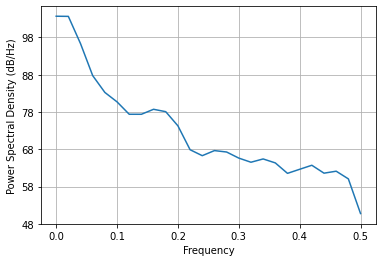

In [22]:
make_welch_periodgram(flu_data.SPEC_RECEIVED_NB,sampling = 50)

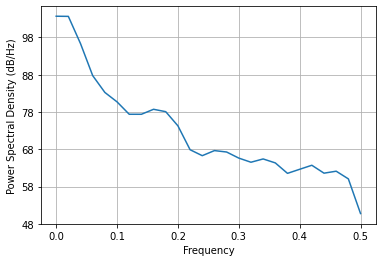

In [23]:
psd = WelchPeriodogram(flu_data.SPEC_RECEIVED_NB,50)

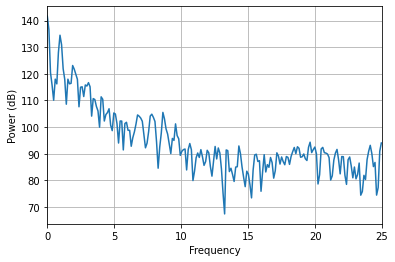

In [24]:
psd = Periodogram(flu_data.SPEC_RECEIVED_NB, 50, scale_by_freq = True)
psd.plot()

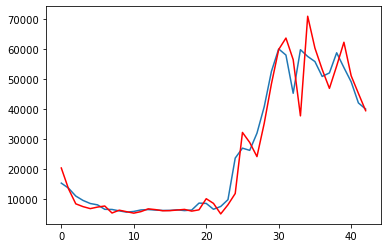

In [25]:
X = flu_data.SPEC_RECEIVED_NB.values
size = int(len(X) * 0.90)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# window MSE 
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

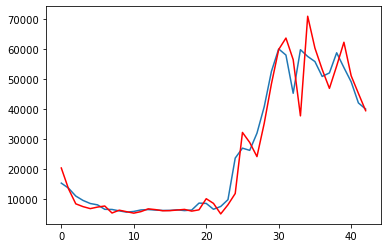

5562.989924450739

In [27]:
arima_window_ase(flu_data.SPEC_RECEIVED_NB, train_ratio = .90, order=(5,1,0))